In [17]:
import numpy as np
from enum import Enum

import matplotlib.pyplot as plt 
%matplotlib notebook

from scipy.ndimage.filters import uniform_filter1d

import nutripy 

In [2]:
CALORIES_STEP_SIZE=250

class Goal(Enum):
    LOSS = -CALORIES_STEP_SIZE
    MAINTAIN = 0
    GAIN = CALORIES_STEP_SIZE

In [3]:
class UnhandledCaseException(Exception):
    pass

In [18]:
nutripy.Goal

AttributeError: module 'nutripy' has no attribute 'Goal'

In [4]:
def is_close(a, b, close=150):
    if abs(a - b) < close:
        return True
    return False

In [5]:
class State:
    pass

class Sequence:
    def __init__(self):
        self.state = {
            "goal": objective,
            "age_in_weeks": 0,
            "phase": Phase.LOSS,
            "dej": dej,
            "mb": mb,
            "aca": aca,
            "weight": 80,
            "weeks_in_phase": 0,
        }
        self.history = deque(maxlen=10)
        
    def get_weight_last_n_weeks(self, n=3):
        if len(self.history) >= n:
            return [x["weight"] for x in self.history][-n:]

In [6]:
class Phase(Enum):
    LOSS = 0
    STOP = 1
    MAINTAINANCE = 2 
    GAIN = 3

In [7]:
def compute_dej(weight, height, age):
    return 1.8 * 191 * (1.083 * weight**0.48) * (height**0.50) * (age**-0.13)

# Simulation 

In [8]:
"""
Model of weight variation over one week
        - aca is the real number of calories eaten per day
        - dej is the estimated daily needs in calories
        - sigma represent the randomness, the higher the value, the higher the random 
          variations of the weight
"""

def next_weight(aca, dej, sigma=.6):
    return np.random.normal(0, sigma) + ((aca - dej) * 7) / 7000 

In [10]:
initial_weight = 80

n_weeks = 100

height = 1.80
age = 30

dej_hat = compute_dej(initial_weight, height, age)
aca = dej_hat



## Build muscle

In [11]:
def gain(x):
    if x > 0.5: 
        return 0
    if x <= 0.5:
        return CALORIES_STEP_SIZE

def maintain(x):
    if x > -0.5 and x < 0.5: 
        return 0
    if x > 0.5:
        return -CALORIES_STEP_SIZE
    if x < 0.5:
        return CALORIES_STEP_SIZE

In [12]:
weight_history = []
aca_history = []

weight_history.append(initial_weight)
aca_history.append(aca)
phases_history = [Phase.GAIN]

for i in range(n_weeks):
    delta_w = next_weight(aca, dej_hat)
    delta_cal = 0
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    
    
    current_phase = phases_history[-1]
    duration = 1
    for i in range(0, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break
            
    #print(duration)
    
    if current_phase == Phase.GAIN and duration <= 16:
        new_phase = Phase.GAIN
        
    
    if current_phase == Phase.GAIN and duration > 16:
        new_phase = Phase.STOP
        duration = 1
        
    if current_phase == Phase.STOP:
        if is_close(dej_hat, aca, close=200):
            new_phase = Phase.MAINTAINANCE
            phases_history.append(new_phase)
         
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])
    
    if new_phase == Phase.GAIN:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = gain(y[-1])
    
    if new_phase == Phase.STOP:
        if duration == 1:
            dej_hat = compute_dej(weight_history[-1], height, age)
        #print(dej_hat)
        if not is_close(dej_hat, aca, close=200):
            delta_cal = -CALORIES_STEP_SIZE
    
    phases_history.append(new_phase)
    aca = aca + delta_cal
    aca_history.append(aca)
    
#    print(aca)

<IPython.core.display.Javascript object>


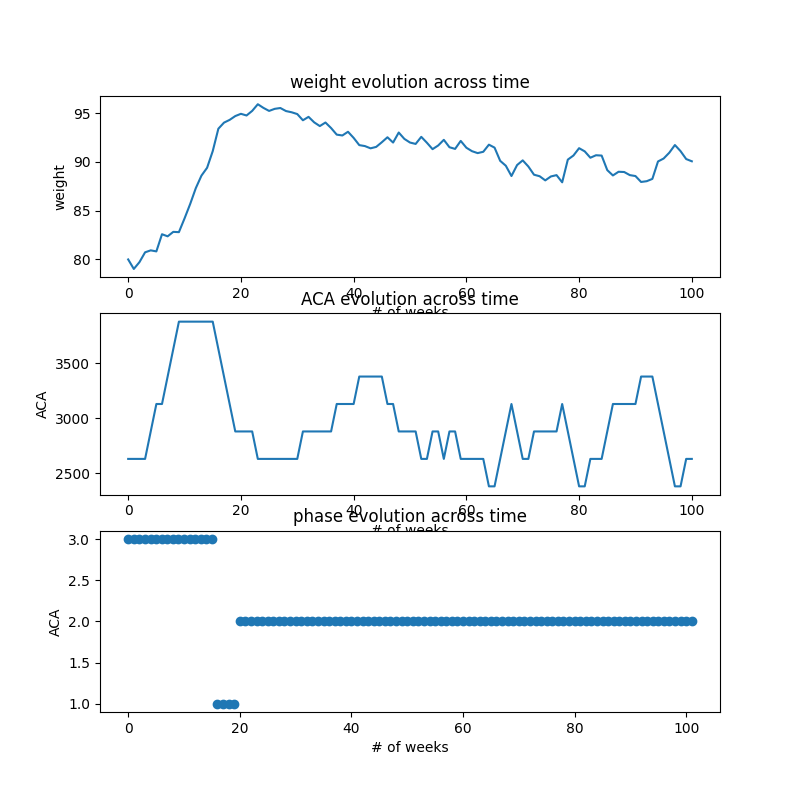

In [13]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()

## Lose Fat

In [14]:
def loss(x):
    if x < -0.5: 
        return 0
    if x > -0.5:
        return -CALORIES_STEP_SIZE

In [15]:
weight_history = []
aca_history = []

weight_history.append(initial_weight)
aca_history.append(aca)
phases_history = [Phase.LOSS]

for i in range(n_weeks):
    delta_w = next_weight(aca, dej_hat)
    delta_cal = 0
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    
    
    current_phase = phases_history[-1]
    duration = 1
    for i in range(0, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break
            
    #print(duration)
    
    if current_phase == Phase.LOSS and duration <= 16:
        new_phase = Phase.LOSS
        
    
    if current_phase == Phase.LOSS and duration > 16:
        new_phase = Phase.STOP
        duration = 1
        
    if current_phase == Phase.STOP:
        if is_close(dej_hat, aca, close=200):
            new_phase = Phase.MAINTAINANCE
            phases_history.append(new_phase)
         
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])
    
    if new_phase == Phase.LOSS:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = loss(y[-1])
    
    if new_phase == Phase.STOP:
        if duration == 1:
            dej_hat = compute_dej(weight_history[-1], height, age)
        #print(dej_hat)
        if not is_close(dej_hat, aca, close=200):
            delta_cal = +CALORIES_STEP_SIZE
    
    phases_history.append(new_phase)
    aca = aca + delta_cal
    aca_history.append(aca)
    
#    print(aca)

<IPython.core.display.Javascript object>


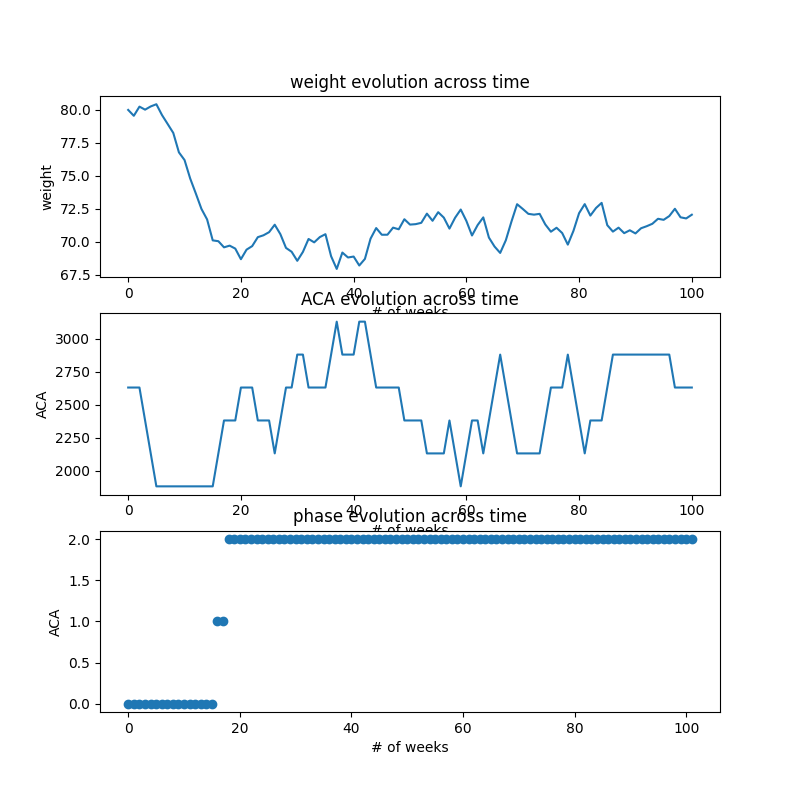

In [16]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()